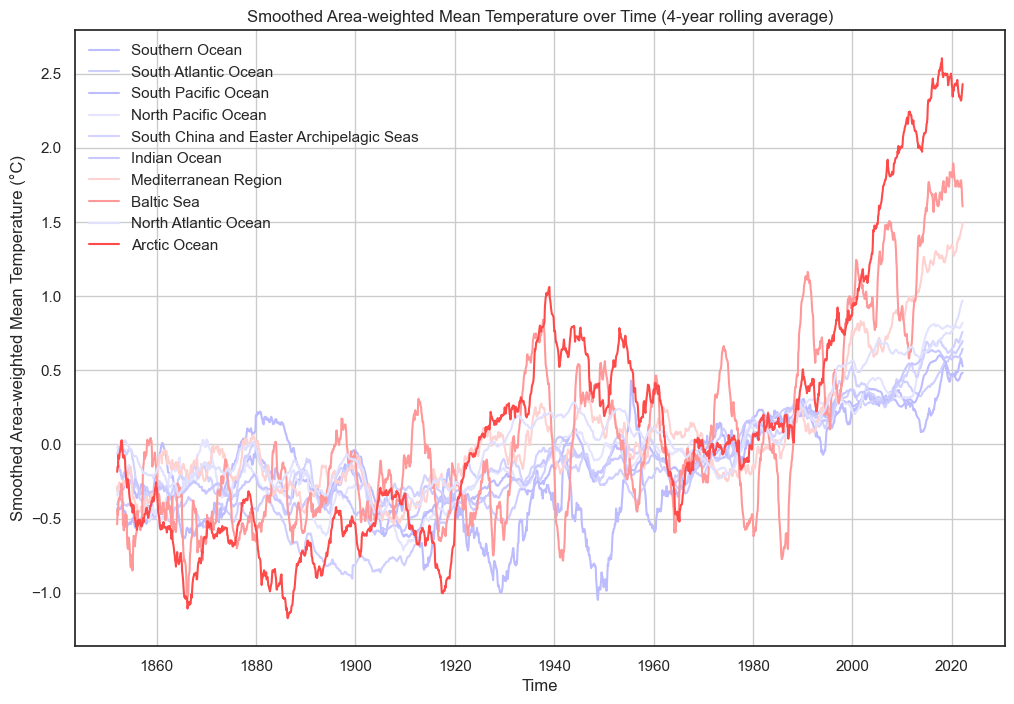

In [179]:
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import rasterio.mask

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.path import Path

def serial_mask(lon, lat, polygon):
    """Masks longitude and latitude by the input shapefile.
    Args:
        lon, lat: longitude and latitude grids.
            (use np.meshgrid if they start as 1D grids)
        polygon: output from `select_shape`. a shapely polygon of the region
                 you want to mask.
    Returns:
        mask: boolean mask with same dimensions as input grids.
    Resource:
       adapted from https://stackoverflow.com/questions/47781496/
                    python-using-polygons-to-create-a-mask-on-a-given-2d-grid
    """
    # You might need to change this...
    if ( (len(lon.shape) != 2) | (len(lat.shape) != 2) ):
        raise ValueError("""Please input a longitude and latitude *grid*.
            I.e., it should be of two dimensions.""")
    # Flatten longitude and latitude grids
    lon1d, lat1d = lon.ravel(), lat.ravel()
    
    # Create a function to check if a point is inside the polygon
    def check_point(point):
        return polygon.contains(Point(point))
    
    # Apply the check to each point in the grid
    mask = np.apply_along_axis(check_point, 1, np.column_stack((lon1d, lat1d)))
    
    # Reshape mask to input grid shape
    mask = mask.reshape(lon.shape)
    
    return mask


def grid_cell_area(lon, lat, mask):
    """Calculate the area of each grid cell within the masked region.
    Args:
        lon, lat: longitude and latitude grids.
            (use np.meshgrid if they start as 1D grids)
        mask: boolean mask with same dimensions as input grids.
    Returns:
        area: array containing the area of each grid cell within the masked region.
    """
    # Calculate the grid cell size in radians
    dlon = np.radians(np.diff(lon, axis=1))[0][0]
    dlat = np.radians(np.diff(lat, axis=0))[0][0]
    
    # Calculate the area of each grid cell
    lon_rad, lat_rad = np.radians(lon), np.radians(lat)
    R = 6371.0  # Earth radius in km
    area = R**2 * np.abs(dlat*dlon * np.cos(lat_rad))
    
    # Mask the area array to consider only the cells within the mask
    masked_area = area * mask
    
    return masked_area


# Read the shapefile
gdf = gpd.read_file("GOaS_v1_20211214/goas_v01.shp")

# Read the xarray dataset
ds = xr.open_dataset("HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean.nc")

# Extract SST variable
sst = ds['tas_mean']

# Perform 4-year moving average on the SST data
sst = sst.rolling(time=48, center=True).mean()

# Compute area weights
weights = np.cos(np.deg2rad(sst.latitude))
weights.name = "weights"

# Initialize an empty list to store area-weighted mean temperatures
area_weighted_temps = []

# Initialize an empty list to store the names
names = []

# Define a colormap ranging from blue to white to red
colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # blue, white, red
cmap_name = 'custom_colormap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

for i, row in gdf.iterrows():
    print(i)
    # Mask the SST data with the geometry using serial_mask function
    mask = serial_mask(lon_mesh, lat_mesh, row.geometry)
    masked_sst = sst.where(mask)
    
    masked_sst = masked_sst.weighted(weights)

    # Calculate the area-weighted mean temperature
    area_weighted_temp = masked_sst.mean(dim=['longitude', 'latitude'])
    
    # Append the result to the list
    area_weighted_temps.append(area_weighted_temp)
    
    # Append the name to the list
    names.append(row['name'])

# Convert the list to a numpy array
area_weighted_temps = np.array(area_weighted_temps)

# Normalize color values based on min and max temperature
norm = plt.Normalize(vmin=-1, vmax=3)

# Plot the area-weighted mean temperatures over time and add legend
plt.figure(figsize=(12, 8))  # Adjust figure size here
for temp, name in zip(area_weighted_temps, names):
    # Get the color based on the value of the final timestep
    final_temp = temp[-50].item()
    color = cm(norm(final_temp))
    
    # Plot the line with the assigned color
    plt.plot(ds.time, temp, label=name, color=color)
    
plt.xlabel('Time')
plt.ylabel('Smoothed Area-weighted Mean Temperature (°C)')
plt.title('Smoothed Area-weighted Mean Temperature over Time (4-year rolling average)')
plt.grid(True)
plt.legend(frameon=False)
plt.show()

